### This notebook is intended to plot hysteresis patterns for the SPRING of 2023 (similar format as summer storm plotting code)

Import all data -  Constituents, water surface elevation (WSE) and sonde turbidity and fDOM to plot hysteresis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.linear_model import LinearRegression

# directory where the CSV files are stored
#directory = 'C:/Users/huck4481/Documents/GitHub/La_Jara/Hysteresis/Spring_2023'

# water depth data
depths = pd.read_csv('2023_water_depths.csv', parse_dates=['Date_Time'], index_col='Date_Time')
# sonde data
down_sonde = pd.read_csv('SP23_down_sonde.csv', parse_dates=['Date_Time'], index_col='Date_Time')
up_sonde = pd.read_csv('SP23_up_sonde.csv', parse_dates=['Date_Time'], index_col='Date_Time')
# nutrient data
down_constituents = pd.read_csv('SP23_down_constituents.csv', parse_dates=['Date_Time'], index_col='Date_Time')
up_constituents = pd.read_csv('SP23_up_constituents.csv', parse_dates=['Date_Time'], index_col='Date_Time')

Plotting the raw turbidity and depth data

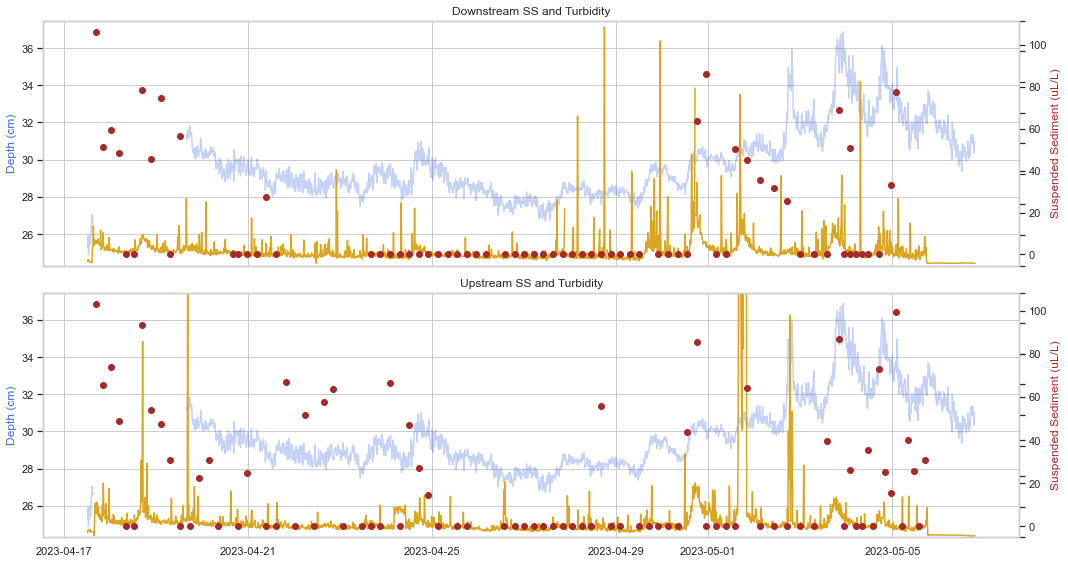

In [3]:
# getting min and max dates from turbidity data
min_date = min(down_sonde.index.min(), up_sonde.index.min())
max_date = max(down_sonde.index.max(), up_sonde.index.max())
# filter depth data
filtered_depths = depths.loc[(depths.index >= min_date) & (depths.index <= max_date)]
# converting depth to cm
filtered_depths = filtered_depths * 100

#plot depth time series for reach
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
sns.set_theme(style="whitegrid")
colors = ['royalblue', 'goldenrod', 'brown']
labels = ['Depth', 'Turbidity', 'Suspended Sediment']
ylabels = ['Depth (cm)', 'Turbidity (NTU)', 'Suspended Sediment (uL/L)']
data = [(down_sonde, down_constituents), (up_sonde, up_constituents)]
titles = ['Downstream SS and Turbidity', 'Upstream SS and Turbidity']

for i, (sonde, constituents) in enumerate(data):
    axes = [ax[i].twinx() if j > 0 else ax[i] for j in range(3)]
    for j, axis in enumerate(axes):
        if j == 0: # depth
            axis.plot(filtered_depths.index, filtered_depths['P3'], label=labels[j], color=colors[j], alpha=0.3)
            axis.grid(True)
            axis.set_ylabel(ylabels[j], color=colors[j])
        elif j == 1: # sonde
            axis.plot(sonde.index, sonde['Turbidity (NTU) (922381)'], label=labels[j], color=colors[j])
            axis.set_ylim(bottom=0, top=200)  # Set y-axis limits for turbidity
            axis.grid(False)
            axis.set_yticklabels([])
        else: # constituents
            axis.plot(constituents.index, constituents['SS (uL/L)'], 'o', label=labels[j], color=colors[j])
            axis.grid(False)
            axis.set_ylabel(ylabels[j], color=colors[j])
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.show()

Cleanup turbidity and water depth Data

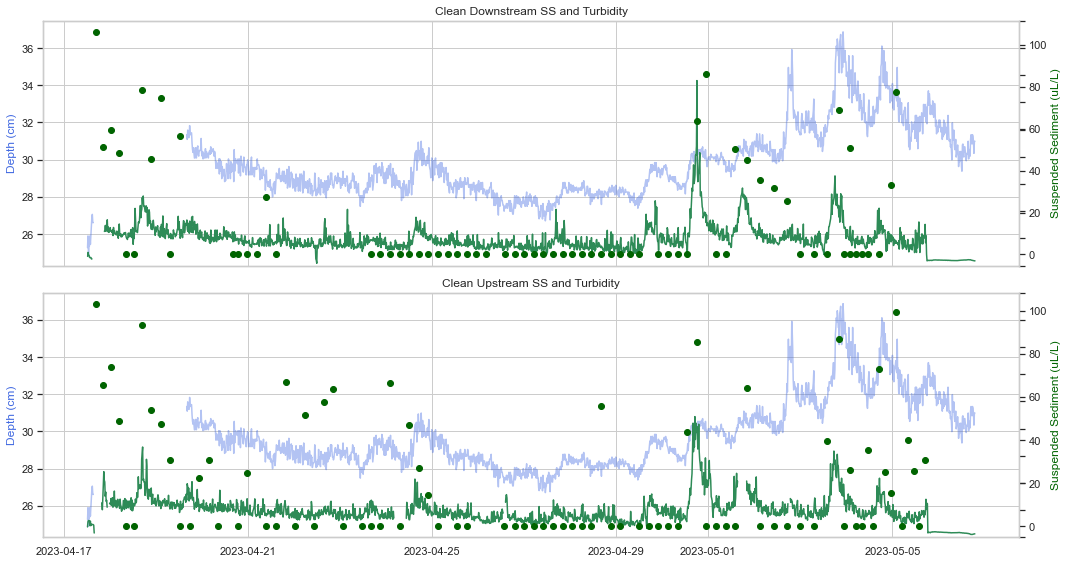

In [4]:
# after processing the data using Turbidity Cleaner Algorithm, import clean data and plot
down_sonde_clean = pd.read_csv('post-turbidity-cleaner/SP23_down_clean_sondeturb.csv', parse_dates=['DateTime'], index_col='DateTime', na_values=-9999)
up_sonde_clean = pd.read_csv('post-turbidity-cleaner/SP23_up_clean_sondeturb.csv', parse_dates=['DateTime'], index_col='DateTime', na_values=-9999)

# getting min and max dates from turbidity data
min_date = min(down_sonde_clean.index.min(), up_sonde_clean.index.min())
max_date = max(down_sonde_clean.index.max(), up_sonde_clean.index.max())
# filter depth data
filtered_depths = depths.loc[(depths.index >= min_date) & (depths.index <= max_date)]
filtered_depths = filtered_depths * 100

#plot depth time series for reach
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
sns.set_theme(style="whitegrid")
colors = ['royalblue', 'seagreen', 'darkgreen']
labels = ['Depth', 'Turbidity', 'Suspended Sediment']
ylabels = ['Depth (cm)', 'Turbidity (NTU)', 'Suspended Sediment (uL/L)']
data = [(down_sonde_clean, down_constituents), (up_sonde_clean, up_constituents)]
titles = ['Clean Downstream SS and Turbidity', 'Clean Upstream SS and Turbidity']

for i, (sonde, constituents) in enumerate(data):
    axes = [ax[i].twinx() if j > 0 else ax[i] for j in range(3)]
    for j, axis in enumerate(axes):
        if j == 0: # depth
            axis.plot(filtered_depths.index, filtered_depths['P3'], label=labels[j], color=colors[j], alpha=0.4)
            axis.grid(True)
            axis.set_ylabel(ylabels[j], color=colors[j])
        elif j == 1: # sonde
            axis.plot(sonde.index, sonde['DataValue'], label=labels[j], color=colors[j])
            axis.set_ylim(bottom=0, top=90)  # Set y-axis limits for turbidity
            axis.grid(False)
            axis.set_yticklabels([])
        else: # constituents
            axis.plot(constituents.index, constituents['SS (uL/L)'], 'o', label=labels[j], color=colors[j])
            axis.grid(False)
            axis.set_ylabel(ylabels[j], color=colors[j])
    ax[i].set_title(titles[i])

plt.tight_layout()
plt.show()

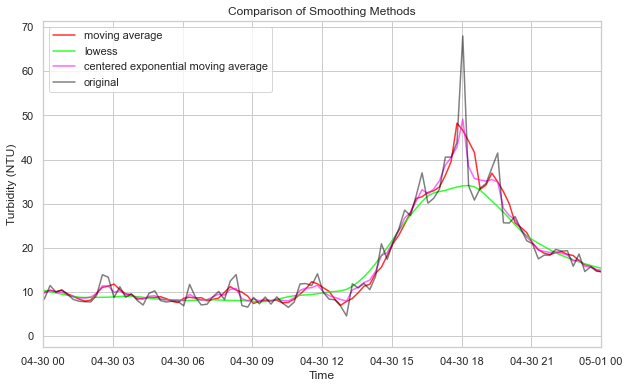

In [6]:
# trying out different smoothing techniques
# moving average
window_size = 4 # this is an hour (4 data points at a 15 minute frequency)
down_sonde_clean['MA_turbidity'] = down_sonde_clean['DataValue'].rolling(window=window_size, center=True).mean()

# lowess smoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
frac = 0.009
down_sonde_clean['lowess_turbidity'] = lowess(down_sonde_clean['DataValue'], down_sonde_clean.index, frac=frac, return_sorted=False)

# exponential moving average
down_sonde_clean['EMA_turbidity'] = down_sonde_clean['DataValue'].ewm(span=window_size, adjust=False).mean()
ema_fwd = down_sonde_clean['DataValue'].ewm(span=window_size, adjust=False).mean() # forward EMA
ema_bwd = down_sonde_clean['DataValue'][::-1].ewm(span=window_size, adjust=False).mean() # backward EMA
centered_EMA = np.sqrt(ema_fwd * ema_bwd[::-1]) # centered EMA
down_sonde_clean['centered_EMA_turbidity'] = np.where(down_sonde_clean['DataValue'].isna(), np.nan, centered_EMA)


# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(down_sonde_clean.index, down_sonde_clean['MA_turbidity'], label='moving average', alpha=0.8, color='red')
plt.plot(down_sonde_clean.index, down_sonde_clean['lowess_turbidity'], label='lowess', alpha=0.8, color='lime')
plt.plot(down_sonde_clean.index, down_sonde_clean['centered_EMA_turbidity'], label='centered exponential moving average', alpha=0.6, color='magenta')
plt.plot(down_sonde_clean.index, down_sonde_clean['DataValue'], label='original', alpha=0.5, color='black')

# Set x-limits to April of the year in the data
plt.xlim([pd.Timestamp(year=int(down_sonde_clean.index.year[0]), month=4, day=30), pd.Timestamp(year=int(down_sonde_clean.index.year[0]), month=5, day=1)])

plt.title('Comparison of Smoothing Methods')
plt.xlabel('Time')
plt.ylabel('Turbidity (NTU)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# the CEMA method seems to be the best smoothing method, and all peaks are captured accurately. 
std_dev = (down_sonde_clean['DataValue'] - down_sonde_clean['MA_turbidity']).std()
print('The standard deviation of the residuals for the moving average is:', round(std_dev, 3), 'NTU')

The standard deviation of the residuals for the moving average is: 1.587 NTU


In [8]:
# smoothing the rest of the data
# upstream turbidity data
ema_fwd = up_sonde_clean['DataValue'].ewm(span=window_size, adjust=False).mean() # forward EMA
ema_bwd = up_sonde_clean['DataValue'][::-1].ewm(span=window_size, adjust=False).mean() # backward EMA
centered_EMA = np.sqrt(ema_fwd * ema_bwd[::-1]) # centered EMA
up_sonde_clean['centered_EMA_turbidity'] = np.where(up_sonde_clean['DataValue'].isna(), np.nan, centered_EMA)

# depth data 
columns = ['P1', 'P2', 'P3']
for col in columns:
    ema_fwd = depths[col].ewm(span=window_size, adjust=False).mean() # forward EMA
    ema_bwd = depths[col][::-1].ewm(span=window_size, adjust=False).mean() # backward EMA
    centered_EMA = np.sqrt(ema_fwd * ema_bwd[::-1]) # centered EMA
    depths[f'{col}_EMA'] = np.where(depths[col].isna(), np.nan, centered_EMA)

Plotting the cleaned turbidity and water depth data 

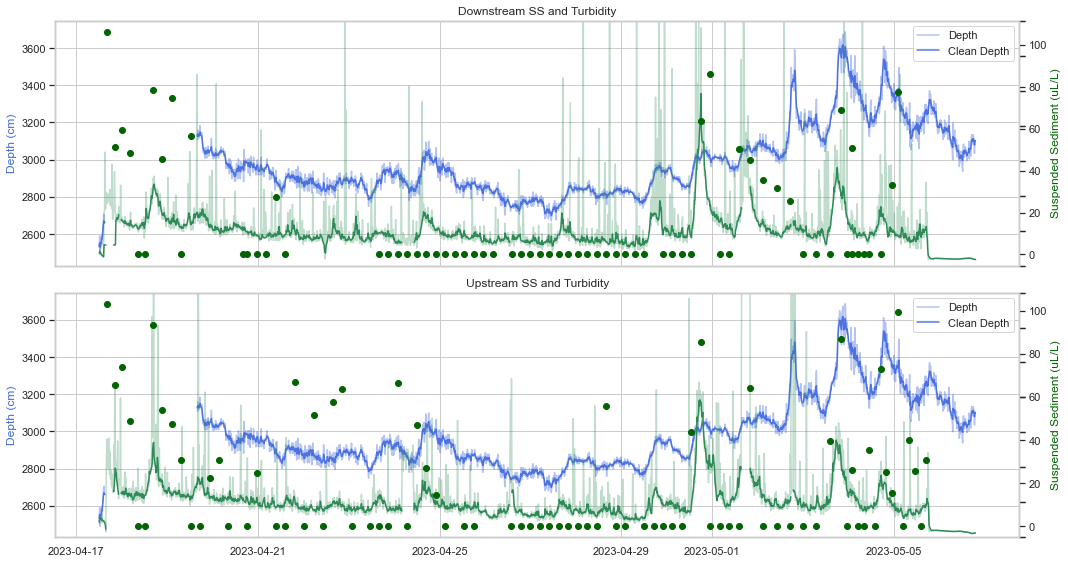

In [13]:
# getting min and max dates from turbidity data
min_date = min(down_sonde_clean.index.min(), up_sonde_clean.index.min())
max_date = max(down_sonde_clean.index.max(), up_sonde_clean.index.max())
# filter depth data (by dates)
filtered_depths = depths.loc[(depths.index >= min_date) & (depths.index <= max_date)]
filtered_depths = filtered_depths * 100
depths = filtered_depths.copy()

#plot depth time series for reach
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
sns.set_theme(style="whitegrid")
colors = ['royalblue', 'seagreen', 'seagreen', 'darkgreen']
labels = ['Depth', 'Original Turbidity', 'Clean Turbidity','Suspended Sediment']
ylabels = ['Depth (cm)', 'Turbidity (NTU)', 'Turbidity (NTU)','Suspended Sediment (uL/L)']
data = [(down_sonde, down_sonde_clean, down_constituents), (up_sonde, up_sonde_clean, up_constituents)]
titles = ['Downstream SS and Turbidity', 'Upstream SS and Turbidity']

for i, (original_sonde, clean_sonde, constituents) in enumerate(data):
    axes = [ax[i].twinx() if j > 0 else ax[i] for j in range(4)]
    for j, axis in enumerate(axes):
        if j == 0: # depth
            axis.plot(filtered_depths.index, filtered_depths['P3'], label=labels[j], color=colors[j], alpha=0.4)
            axis.plot(filtered_depths.index, filtered_depths['P3_EMA'], label='Clean '+labels[j], color=colors[j], alpha=0.9)
            axis.grid(True)
            axis.set_ylabel(ylabels[j], color=colors[j])
        elif j == 1: # original sonde
            axis.plot(original_sonde.index, original_sonde['Turbidity (NTU) (922381)'], label=labels[j], color=colors[j], alpha=0.3)
            axis.set_ylim(bottom=0, top=70)  # Set y-axis limits for turbidity
            axis.grid(False)
            axis.set_yticklabels([])
        elif j == 2: # clean sonde
            axis.plot(clean_sonde.index, clean_sonde['centered_EMA_turbidity'], label='Clean '+labels[j], color=colors[j])
            axis.set_ylim(bottom=0, top=70)
            axis.grid(False)
            axis.set_yticklabels([])
        else: # constituents
            axis.plot(constituents.index, constituents['SS (uL/L)'], 'o', label=labels[j], color=colors[j])
            axis.grid(False)
            axis.set_ylabel(ylabels[j], color=colors[j])
    ax[i].set_title(titles[i])
    ax[i].legend()

plt.tight_layout()
plt.show()

Determination of high flow events - Downstream

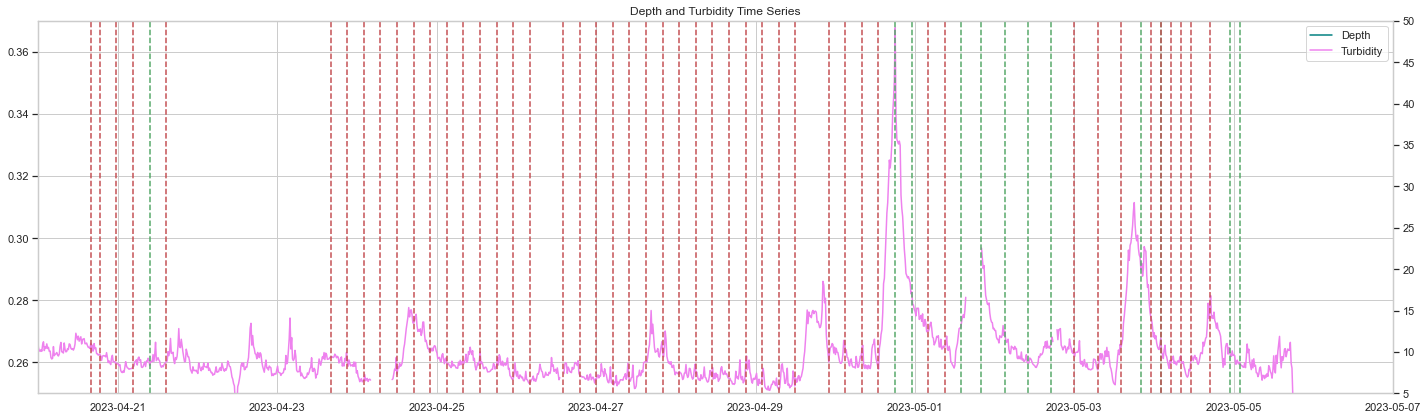

In [14]:
plt.figure(figsize=(20, 6))
line1, = plt.plot(depths.index, depths['P3_EMA'], color='teal', label='Depth')
plt.ylim([0.25, 0.37]) # set y-limits for water depth
ax = plt.gca().twinx() # twin axis for turbidity data
line2, = ax.plot(down_sonde_clean.index, down_sonde_clean['centered_EMA_turbidity'], color='violet', label='Turbidity')
ax.grid(False)
ax.set_ylim([5, 50] ) # set y-limits for turbidity
plt.title('Depth and Turbidity Time Series')

# Create a legend for the whole figure
plt.legend(handles=[line1, line2], labels=['Depth', 'Turbidity'])

for timestamp, value in down_constituents['SS (uL/L)'].items():
    if value != 0:
        plt.axvline(x=timestamp, color='g', linestyle='--')
    else:
        plt.axvline(x=timestamp, color='r', linestyle='--')

# Set x-limits to April of the year in the data
plt.xlim([pd.Timestamp(year=int(depths.index.year[0]), month=4, day=20, hour=0), pd.Timestamp(year=int(depths.index.year[0]), month=5, day=7, hour=0)])
#plt.savefig('depth_turbidity_time_series_apr30-may05.png')
#plt.savefig('SP23_event4.png')
plt.savefig('SP23_full_record.png')
plt.tight_layout()
plt.show()


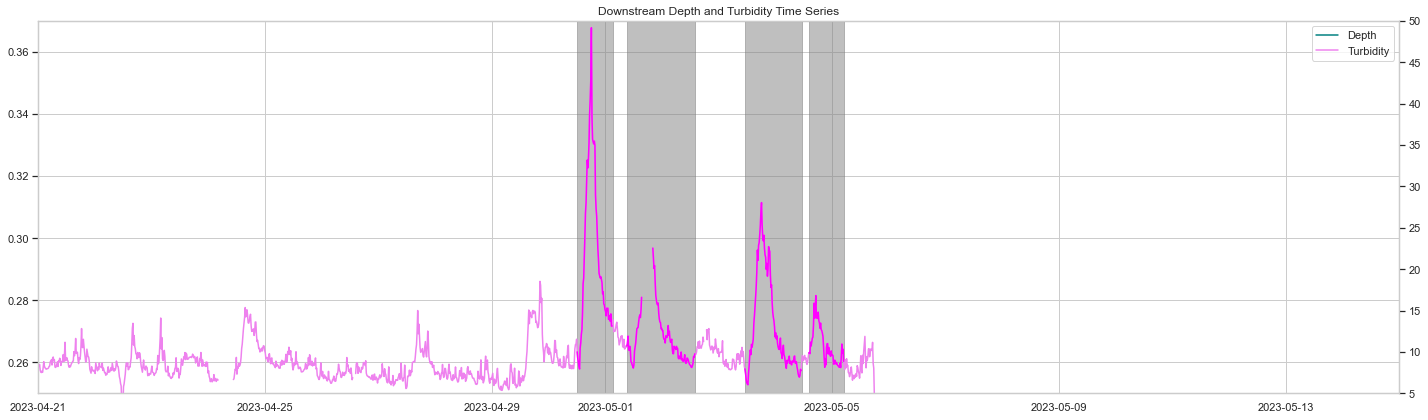

In [15]:
plt.figure(figsize=(20, 6))
line1, = plt.plot(depths.index, depths['P3_EMA'], color='teal', label='Depth')
plt.ylim([0.25, 0.37]) # set y-limits for water depth
ax = plt.gca().twinx() # twin axis for turbidity data
line2, = ax.plot(down_sonde_clean.index, down_sonde_clean['centered_EMA_turbidity'], color='violet', label='Turbidity')
ax.grid(False)
ax.set_ylim([5, 50] ) # set y-limits for turbidity
plt.title('Downstream Depth and Turbidity Time Series')

# Create a legend for the whole figure
plt.legend(handles=[line1, line2], labels=['Depth', 'Turbidity'])

# Set x-limits to April of the year in the data
plt.xlim([pd.Timestamp(year=int(depths.index.year[0]), month=4, day=21, hour=0), pd.Timestamp(year=int(depths.index.year[0]), month=5, day=15, hour=0)])

# List of high flow events (replace with your actual dates)
high_flow_events = [
    (pd.Timestamp('2023-04-30 12:00:00'), pd.Timestamp('2023-05-01 03:00:00')), #event 1
    (pd.Timestamp('2023-05-01 09:00:00'), pd.Timestamp('2023-05-02 14:00:00')), # event 2
    (pd.Timestamp('2023-05-03 11:00:00'), pd.Timestamp('2023-05-04 11:00:00')), # event 3
    (pd.Timestamp('2023-05-04 14:00:00'), pd.Timestamp('2023-05-05 05:00:00'))   # event 4
]

for start, end in high_flow_events:
    # Add shaded region
    plt.axvspan(start, end, color='grey', alpha=0.5)

    # Highlight depth and turbidity data
    line1, = plt.plot(depths.loc[start:end].index, depths.loc[start:end]['P3_EMA'], color='darkturquoise', label='Depth')
    line2, = ax.plot(down_sonde_clean.loc[start:end].index, down_sonde_clean.loc[start:end]['centered_EMA_turbidity'], color='magenta', label='Turbidity')

plt.tight_layout()
plt.savefig('SP23_downstream_events.png')
plt.show()

Peak depth for event from 2023-04-30 12:00:00 to 2023-05-01 03:00:00 occurred at 2023-04-30 20:30:00
Peak depth for event from 2023-05-01 09:00:00 to 2023-05-02 14:00:00 occurred at 2023-05-02 01:15:00
Peak depth for event from 2023-05-03 11:00:00 to 2023-05-04 11:00:00 occurred at 2023-05-03 21:00:00
Peak depth for event from 2023-05-04 14:00:00 to 2023-05-05 05:00:00 occurred at 2023-05-04 18:30:00


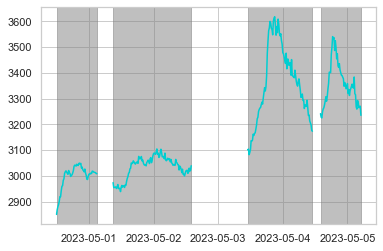

In [16]:
for start, end in high_flow_events:
    # Add shaded region
    plt.axvspan(start, end, color='grey', alpha=0.5)

    # Highlight depth and turbidity data
    line1, = plt.plot(depths.loc[start:end].index, depths.loc[start:end]['P3_EMA'], color='darkturquoise', label='Depth')
    line2, = ax.plot(down_sonde_clean.loc[start:end].index, down_sonde_clean.loc[start:end]['centered_EMA_turbidity'], color='magenta', label='Turbidity')

    # Find the time of the peak depth
    peak_depth_time = depths.loc[start:end, 'P3_EMA'].idxmax()
    print(f"Peak depth for event from {start} to {end} occurred at {peak_depth_time}")

Determining high flow events - Upstream

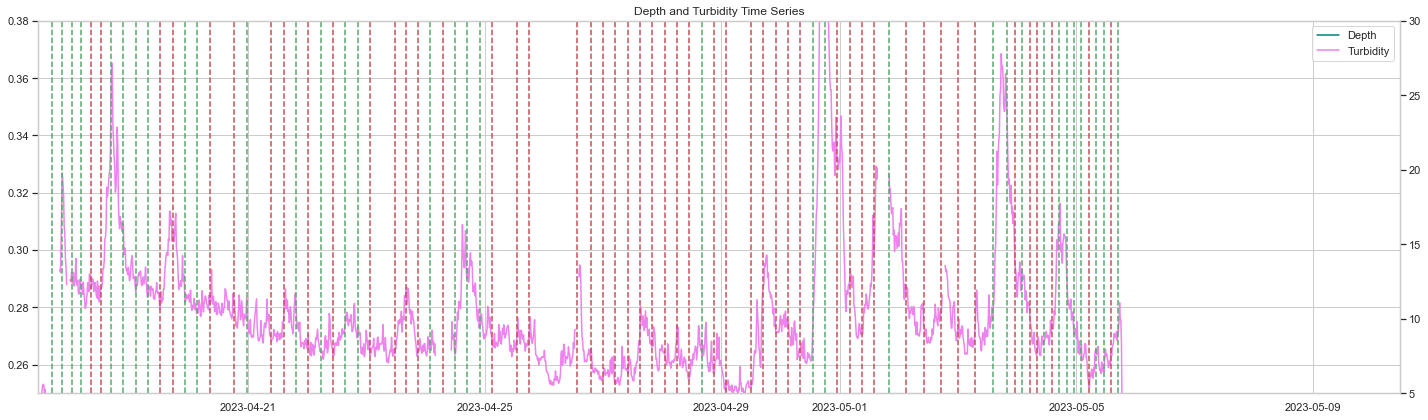

In [17]:
plt.figure(figsize=(20, 6))
line1, = plt.plot(depths.index, depths['P3_EMA'], color='teal', label='Depth')
plt.ylim([0.25, 0.38]) # set y-limits for water depth
ax = plt.gca().twinx() # twin axis for turbidity data
line2, = ax.plot(up_sonde_clean.index, up_sonde_clean['centered_EMA_turbidity'], color='violet', label='Turbidity')
ax.grid(False)
ax.set_ylim([5, 30] ) # set y-limits for turbidity
plt.title('Depth and Turbidity Time Series')

# Create a legend for the whole figure
plt.legend(handles=[line1, line2], labels=['Depth', 'Turbidity'])

for timestamp, value in up_constituents['SS (uL/L)'].items():
    if value != 0:
        plt.axvline(x=timestamp, color='g', linestyle='--')
    else:
        plt.axvline(x=timestamp, color='r', linestyle='--')

# Set x-limits to April of the year in the data
plt.xlim([pd.Timestamp(year=int(depths.index.year[0]), month=4, day=17, hour=11), pd.Timestamp(year=int(depths.index.year[0]), month=5, day=10, hour=11)])
#plt.savefig('up_depth_turbidity_time_series_apr25-30.png')
#plt.savefig('SP23_event3_up.png')
plt.tight_layout()
plt.show()

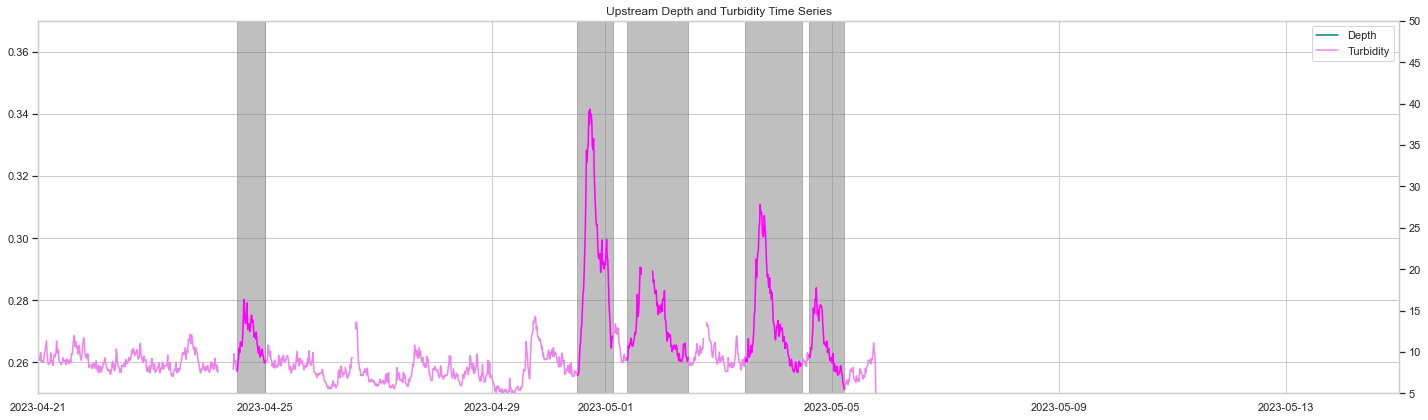

In [18]:
plt.figure(figsize=(20, 6))
line1, = plt.plot(depths.index, depths['P3_EMA'], color='teal', label='Depth')
plt.ylim([0.25, 0.37]) # set y-limits for water depth
ax = plt.gca().twinx() # twin axis for turbidity data
line2, = ax.plot(up_sonde_clean.index, up_sonde_clean['centered_EMA_turbidity'], color='violet', label='Turbidity')
ax.grid(False)
ax.set_ylim([5, 50] ) # set y-limits for turbidity
plt.title('Upstream Depth and Turbidity Time Series')

# Create a legend for the whole figure
plt.legend(handles=[line1, line2], labels=['Depth', 'Turbidity'])

# Set x-limits to April of the year in the data
plt.xlim([pd.Timestamp(year=int(depths.index.year[0]), month=4, day=21, hour=0), pd.Timestamp(year=int(depths.index.year[0]), month=5, day=15, hour=0)])

# List of high flow events (replace with your actual dates)
high_flow_events = [
    (pd.Timestamp('2023-04-24 12:00:00'), pd.Timestamp('2023-04-25 00:00:00')), #event 0
    (pd.Timestamp('2023-04-30 12:00:00'), pd.Timestamp('2023-05-01 03:00:00')), #event 1
    (pd.Timestamp('2023-05-01 09:00:00'), pd.Timestamp('2023-05-02 11:00:00')), # event 2
    (pd.Timestamp('2023-05-03 11:00:00'), pd.Timestamp('2023-05-04 11:00:00')), # event 3
    (pd.Timestamp('2023-05-04 14:00:00'), pd.Timestamp('2023-05-05 05:00:00'))   # event 4
]

for start, end in high_flow_events:
    # Add shaded region
    plt.axvspan(start, end, color='grey', alpha=0.5)

    # Highlight depth and turbidity data
    line1, = plt.plot(depths.loc[start:end].index, depths.loc[start:end]['P3_EMA'], color='darkturquoise', label='Depth')
    line2, = ax.plot(up_sonde_clean.loc[start:end].index, up_sonde_clean.loc[start:end]['centered_EMA_turbidity'], color='magenta', label='Turbidity')

plt.tight_layout()
plt.savefig('SP23_upstream_events.png')
plt.show()

Peak depth for event from 2023-04-24 12:00:00 to 2023-04-25 00:00:00 occurred at 2023-04-24 18:15:00
Peak depth for event from 2023-04-30 12:00:00 to 2023-05-01 03:00:00 occurred at 2023-04-30 20:30:00
Peak depth for event from 2023-05-01 09:00:00 to 2023-05-02 11:00:00 occurred at 2023-05-02 01:15:00
Peak depth for event from 2023-05-03 11:00:00 to 2023-05-04 11:00:00 occurred at 2023-05-03 21:00:00
Peak depth for event from 2023-05-04 14:00:00 to 2023-05-05 05:00:00 occurred at 2023-05-04 18:30:00


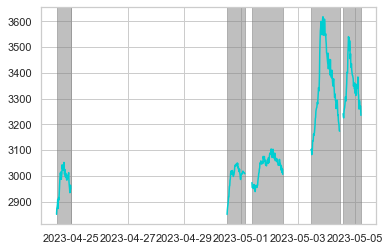

In [19]:
for start, end in high_flow_events:
    # Add shaded region
    plt.axvspan(start, end, color='grey', alpha=0.5)

    # Highlight depth and turbidity data
    line1, = plt.plot(depths.loc[start:end].index, depths.loc[start:end]['P3_EMA'], color='darkturquoise', label='Depth')
    line2, = ax.plot(down_sonde_clean.loc[start:end].index, down_sonde_clean.loc[start:end]['centered_EMA_turbidity'], color='magenta', label='Turbidity')

    # Find the time of the peak depth
    peak_depth_time = depths.loc[start:end, 'P3_EMA'].idxmax()
    print(f"Peak depth for event from {start} to {end} occurred at {peak_depth_time}")

Definition of hysteresis plotting function

In [20]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    # Ensure z is a 1D array with the same length as x and y
    if z is None:
        z = np.arange(len(x))  # Use the index of the point as the color
    elif not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z] * len(x))
    else:
        z = np.asarray(z)

    # Remove NaN values
    mask = ~np.isnan(y)
    x, y = x[mask], y[mask]

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)

    return lc

### Plotting hysteresis - Downstream
before plotting hysteresis we need to clean up the fdom data

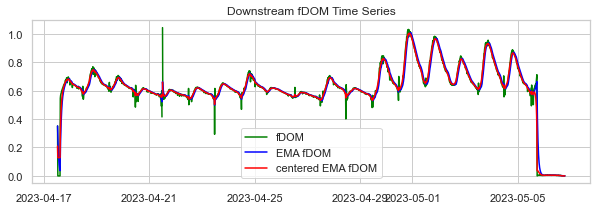

In [39]:
# plot fdom time series
plt.figure(figsize=(10, 3))
plt.plot(down_sonde.index, down_sonde['FDOM Fluorescence (RFU) (910042)'], color='green', label='fDOM')
# exponential moving average
window_size = 8 # this is two hours (8 data points at a 15 minute frequency)
down_sonde['EMA_fDOM'] = down_sonde['FDOM Fluorescence (RFU) (910042)'].ewm(span=window_size, adjust=False).mean()
ema_fwd = down_sonde['FDOM Fluorescence (RFU) (910042)'].ewm(span=window_size, adjust=False).mean() # forward EMA
ema_bwd = down_sonde['FDOM Fluorescence (RFU) (910042)'][::-1].ewm(span=window_size, adjust=False).mean() # backward EMA
centered_EMA = np.sqrt(ema_fwd * ema_bwd[::-1]) # centered EMA
down_sonde['centered_EMA_fDOM'] = np.where(down_sonde['FDOM Fluorescence (RFU) (910042)'].isna(), np.nan, centered_EMA)
# plot the EMA and centered EMA 
plt.plot(down_sonde.index, down_sonde['EMA_fDOM'], color='blue', label='EMA fDOM')
plt.plot(down_sonde.index, down_sonde['centered_EMA_fDOM'], color='red', label='centered EMA fDOM')
plt.title('Downstream fDOM Time Series')
plt.legend()
plt.show()


Event 1

In [40]:
# need to assign the depth and constituent data for each event
depths = depths.dropna(how='all', axis=1)                   # drop columns where all values are NaN
depths = depths.resample('1T').interpolate()                # resampling with a 1 min interval
# make sure depth index is in date time format
depths.index = pd.to_datetime(depths.index)
# event 1
event1_start = pd.Timestamp('2023-04-30 12:00:00') # start
event1_end = pd.Timestamp('2023-05-01 03:00:00') # end

event1_down_sonde = down_sonde_clean.loc[event1_start:event1_end]
event1_down_sonde = event1_down_sonde.join(down_sonde['centered_EMA_fDOM'])

event1_down_constituents = down_constituents.loc[pd.Timestamp('2023-04-30 8:00:00'):pd.Timestamp('2023-05-01 4:00:00')]
# need to merge the depth and rest of data
event1_down_sonde = event1_down_sonde.merge(depths, left_index=True, right_index=True, how='left')
event1_down_constituents = event1_down_constituents.merge(depths, left_index=True, right_index=True, how='left')

downstream_events/event1/event1_down_SS_uL_L.jpg


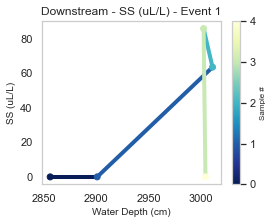

downstream_events/event1/event1_down_DOC_mg_L.jpg


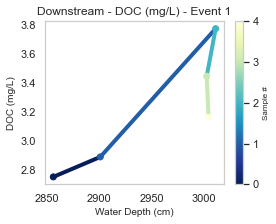

downstream_events/event1/event1_down_POC_mg_L.jpg


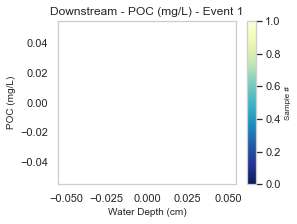

downstream_events/event1/event1_down_N_mg_L.jpg


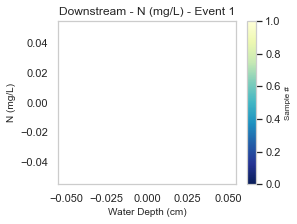

In [22]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event1_down_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event1_down_constituents[constituent])
    x = event1_down_constituents['P3_EMA'][mask]
    y = event1_down_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Downstream - {constituent} - Event 1', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event1/event1_down_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

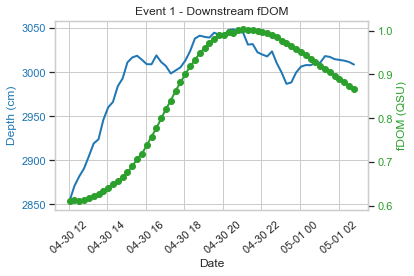

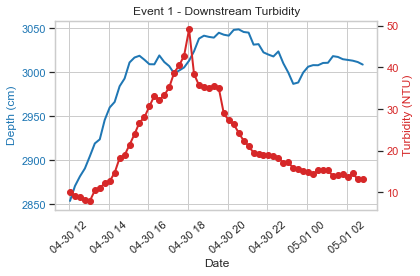

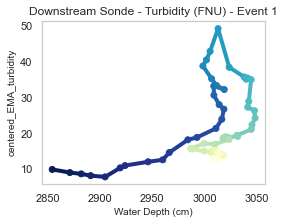

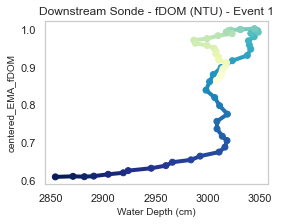

In [42]:
# Sonde for Event 1
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event1_down_sonde.index, event1_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event1_down_sonde.index, event1_down_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 1 - Downstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event1/event1_downstream_down_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event1_down_sonde.index, event1_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event1_down_sonde.index, event1_down_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 1 - Downstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event1/event1_down_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituent_names = ['Turbidity (FNU)', 'fDOM (NTU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))

cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event1_down_sonde['P3_EMA']))
    num_points = len(event1_down_sonde['P3_EMA'])
    colorline(event1_down_sonde['P3_EMA'], event1_down_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event1_down_sonde['P3_EMA'], event1_down_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Downstream Sonde - {constituent_dict[constituent]} - Event 1', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event1/event1_hysteresis_down_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 2

In [58]:
# event 2
event2_start = pd.Timestamp('2023-05-01 10:00:00') # start   
event2_end = pd.Timestamp('2023-05-02 11:00:00') # end
event2_down_sonde = down_sonde_clean.loc[event2_start:event2_end]
event2_down_sonde = event2_down_sonde.join(down_sonde['centered_EMA_fDOM'])
event2_down_constituents = down_constituents.loc[pd.Timestamp('2023-05-01 09:00:00'):pd.Timestamp('2023-05-02 10:00:00')]

# need to merge the depth and rest of data
event2_down_sonde = event2_down_sonde.merge(depths, left_index=True, right_index=True, how='left')
event2_down_constituents = event2_down_constituents.merge(depths, left_index=True, right_index=True, how='left')
event2_down_constituents

,WSE,Q,SS (uL/L),SRP (mg/L),TP (mg/L),DOC (mg/L),POC (mg/L),N (mg/L),PP (mg/L),LAB ID,P1,P2,P3,P1_EMA,P2_EMA,P3_EMA
Date_Time,,,,,,,,,,,,,,,,
2023-05-01 09:00:00,NaN,NaN,0.00,NaN,NaN,2.959,NaN,NaN,NaN,326,1444.7,2279.5,2989.0,1442.142788,2269.211955,2973.684124
2023-05-01 14:00:00,NaN,NaN,50.13,NaN,NaN,3.148,NaN,NaN,NaN,327,1462.2,2272.6,2979.0,1446.876091,2272.518802,2978.557870
2023-05-01 20:00:00,NaN,NaN,44.99,NaN,NaN,3.541,2.29,1.074,NaN,343,1438.9,2337.5,3074.0,1444.846588,2328.886110,3061.399375
2023-05-02 03:00:00,NaN,NaN,35.73,NaN,NaN,3.076,NaN,NaN,NaN,344,1409.7,2354.5,3099.0,1425.395968,2348.412965,3090.041813
2023-05-02 10:00:00,NaN,NaN,31.62,NaN,NaN,2.856,NaN,NaN,NaN,345,1403.9,2317.0,3044.0,1404.623230,2310.010927,3033.763239


downstream_events/event2/event2_down_SS_uL_L.jpg


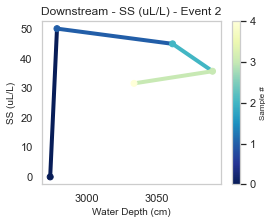

downstream_events/event2/event2_down_DOC_mg_L.jpg


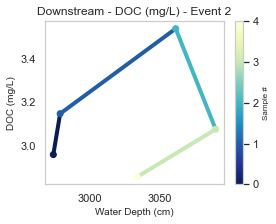

downstream_events/event2/event2_down_POC_mg_L.jpg


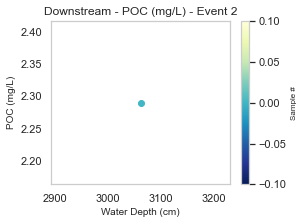

downstream_events/event2/event2_down_N_mg_L.jpg


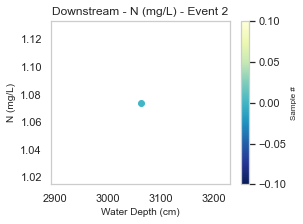

In [59]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event2_down_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event2_down_constituents[constituent])
    x = event2_down_constituents['P3_EMA'][mask]
    y = event2_down_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Downstream - {constituent} - Event 2', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event2/event2_down_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

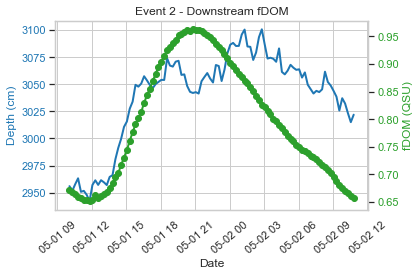

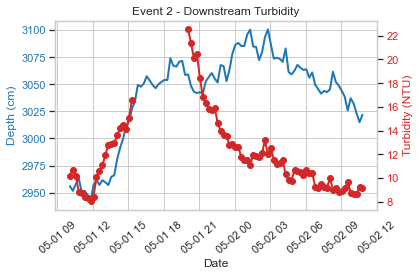

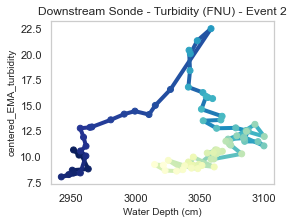

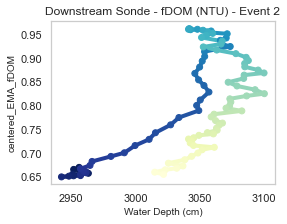

In [60]:
# Sonde for Event 2
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event2_down_sonde.index, event2_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event2_down_sonde.index, event2_down_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 2 - Downstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event1/event1_down_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event2_down_sonde.index, event2_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event2_down_sonde.index, event2_down_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 2 - Downstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event2/event2_down_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituent_names = ['Turbidity (FNU)', 'fDOM (NTU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event2_down_sonde['P3_EMA']))
    num_points = len(event2_down_sonde['P3_EMA'])
    colorline(event2_down_sonde['P3_EMA'], event2_down_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event2_down_sonde['P3_EMA'], event2_down_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Downstream Sonde - {constituent_dict[constituent]} - Event 2', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event2/event2_hysteresis_down_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 3

In [61]:
# event 3
event3_start = pd.Timestamp('2023-05-03 11:00:00') # start
event3_end = pd.Timestamp('2023-05-04 11:00:00') # end
event3_down_sonde = down_sonde_clean.loc[event3_start:event3_end]
event3_down_sonde = event3_down_sonde.join(down_sonde['centered_EMA_fDOM'])
event3_down_constituents = down_constituents.loc[pd.Timestamp('2023-05-03 07:00:00'):pd.Timestamp('2023-05-04 11:00:00')]
# need to merge the depth and rest of data
event3_down_sonde = event3_down_sonde.merge(depths, left_index=True, right_index=True, how='left')
event3_down_constituents = event3_down_constituents.merge(depths, left_index=True, right_index=True, how='left')

downstream_events/event3/event3_down_SS_uL_L.jpg


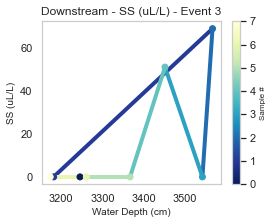

downstream_events/event3/event3_down_DOC_mg_L.jpg


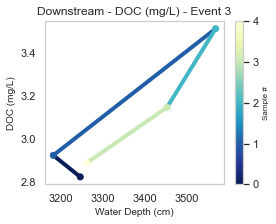

downstream_events/event3/event3_down_POC_mg_L.jpg


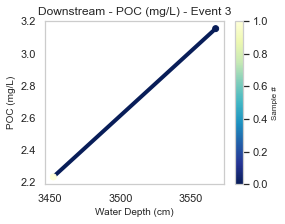

downstream_events/event3/event3_down_N_mg_L.jpg


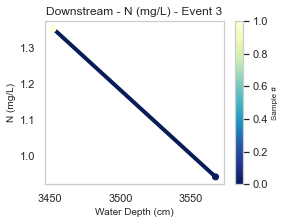

In [62]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event3_down_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event3_down_constituents[constituent])
    x = event3_down_constituents['P3_EMA'][mask]
    y = event3_down_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Downstream - {constituent} - Event 3', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event3/event3_down_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

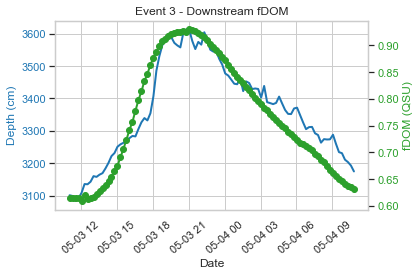

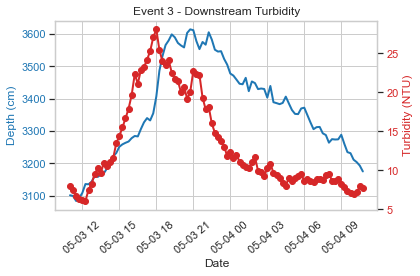

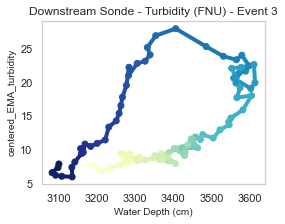

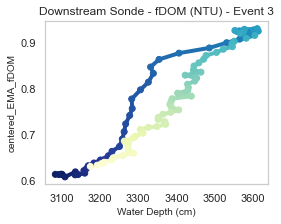

In [63]:
# Sonde for Event 3
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event3_down_sonde.index, event3_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event3_down_sonde.index, event3_down_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 3 - Downstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event3/event3_down_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event3_down_sonde.index, event3_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event3_down_sonde.index, event3_down_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 3 - Downstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event3/event3_down_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituent_name = ['Turbidity (FNU)', 'fDOM (NTU))'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event3_down_sonde['P3_EMA']))
    num_points = len(event3_down_sonde['P3_EMA'])
    colorline(event3_down_sonde['P3_EMA'], event3_down_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event3_down_sonde['P3_EMA'], event3_down_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Downstream Sonde - {constituent_dict[constituent]} - Event 3', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event3/event3_hysteresis_down_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 4

In [64]:
# event 3
event4_start = pd.Timestamp('2023-05-04 14:00:00') # start
event4_end = pd.Timestamp('2023-05-05 05:00:00') # end
event4_down_sonde = down_sonde_clean.loc[event4_start:event4_end]
event4_down_sonde = event4_down_sonde.join(down_sonde['centered_EMA_fDOM'])
event4_down_constituents = down_constituents.loc[pd.Timestamp('2023-05-04 08:00:00'):pd.Timestamp('2023-05-05 02:00:00')]
# need to merge the depth and rest of data
event4_down_sonde = event4_down_sonde.merge(depths, left_index=True, right_index=True, how='left')
event4_down_constituents = event4_down_constituents.merge(depths, left_index=True, right_index=True, how='left')

downstream_events/event4/event4_down_SS_uL_L.jpg


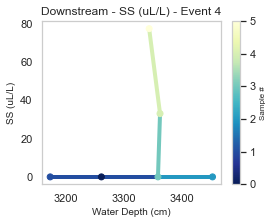

downstream_events/event4/event4_down_DOC_mg_L.jpg


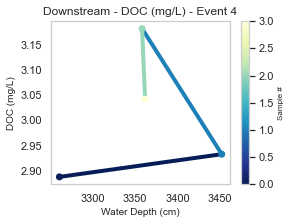

downstream_events/event4/event4_down_POC_mg_L.jpg


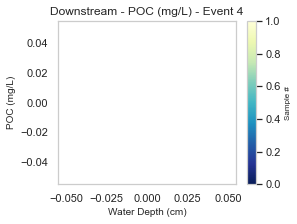

downstream_events/event4/event4_down_N_mg_L.jpg


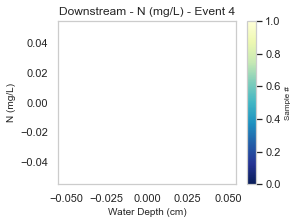

In [65]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event4_down_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event4_down_constituents[constituent])
    x = event4_down_constituents['P3_EMA'][mask]
    y = event4_down_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Downstream - {constituent} - Event 4', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event4/event4_down_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

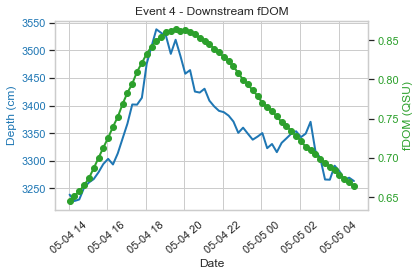

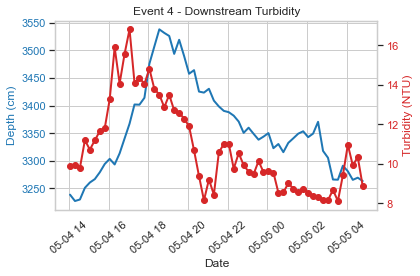

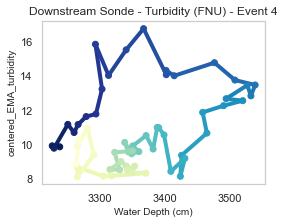

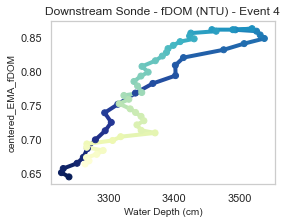

In [66]:
# Sonde for Event 4
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event4_down_sonde.index, event4_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event4_down_sonde.index, event4_down_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 4 - Downstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event4/event4_down_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event4_down_sonde.index, event4_down_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event4_down_sonde.index, event4_down_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 4 - Downstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("downstream_events/event4/event4_down_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituen_name = ['Turbidity (FNU)', 'fDOM (FNU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event4_down_sonde['P3_EMA']))
    num_points = len(event4_down_sonde['P3_EMA'])
    colorline(event4_down_sonde['P3_EMA'], event4_down_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event4_down_sonde['P3_EMA'], event4_down_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Downstream Sonde - {constituent_dict[constituent]} - Event 4', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"downstream_events/event4/event4_hysteresis_down_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

### Plotting hysteresis - Upstream

need to smooth out the fDOM data upstream

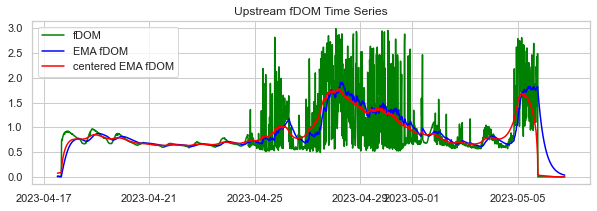

In [47]:
# plot fdom time series
plt.figure(figsize=(10, 3))
plt.plot(up_sonde.index, up_sonde['FDOM Fluorescence (RFU) (910042)'], color='green', label='fDOM')
# exponential moving average
window_size = 50 # this is two hours (8 data points at a 15 minute frequency)
up_sonde['EMA_fDOM'] = up_sonde['FDOM Fluorescence (RFU) (910042)'].ewm(span=window_size, adjust=False).mean()
ema_fwd = up_sonde['FDOM Fluorescence (RFU) (910042)'].ewm(span=window_size, adjust=False).mean() # forward EMA
ema_bwd = up_sonde['FDOM Fluorescence (RFU) (910042)'][::-1].ewm(span=window_size, adjust=False).mean() # backward EMA
centered_EMA = np.sqrt(ema_fwd * ema_bwd[::-1]) # centered EMA
up_sonde['centered_EMA_fDOM'] = np.where(up_sonde['FDOM Fluorescence (RFU) (910042)'].isna(), np.nan, centered_EMA)
# plot the EMA and centered EMA 
plt.plot(up_sonde.index, up_sonde['EMA_fDOM'], color='blue', label='EMA fDOM')
plt.plot(up_sonde.index, up_sonde['centered_EMA_fDOM'], color='red', label='centered EMA fDOM')
plt.title('Upstream fDOM Time Series')
plt.legend()
plt.show()

Event 0

In [67]:
# event 0 (only captured upstream?)
event0_start = pd.Timestamp('2023-04-24 10:00:00') # start
event0_end = pd.Timestamp('2023-04-24 23:00:00') # end
event0_up_sonde = up_sonde_clean.loc[event0_start:event0_end]
event0_up_sonde = event0_up_sonde.join(up_sonde['centered_EMA_fDOM'])
event0_up_constituents = up_constituents.loc[pd.Timestamp('2023-04-24 00:00:00'):pd.Timestamp('2023-04-25 00:00:00')]
# need to merge the depth and rest of data
event0_up_sonde = event0_up_sonde.merge(depths, left_index=True, right_index=True, how='left')
event0_up_constituents = event0_up_constituents.merge(depths, left_index=True, right_index=True, how='left')

upstream_events/event0/event0_up_SS_uL_L.jpg


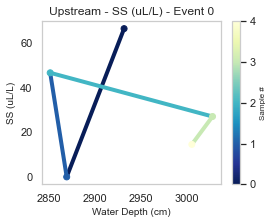

upstream_events/event0/event0_up_DOC_mg_L.jpg


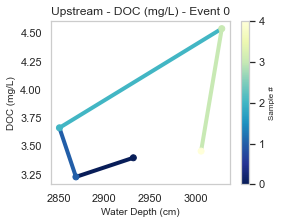

upstream_events/event0/event0_up_POC_mg_L.jpg


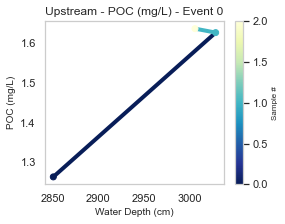

upstream_events/event0/event0_up_N_mg_L.jpg


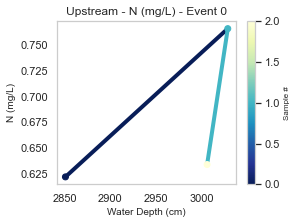

In [68]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event0_up_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event0_up_constituents[constituent])
    x = event0_up_constituents['P3_EMA'][mask]
    y = event0_up_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Upstream - {constituent} - Event 0', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event0/event0_up_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

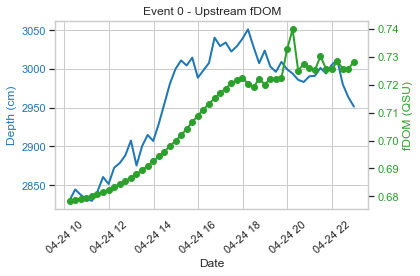

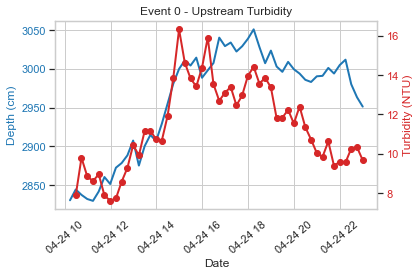

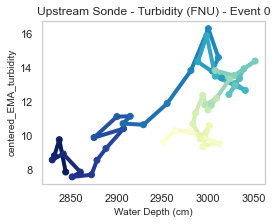

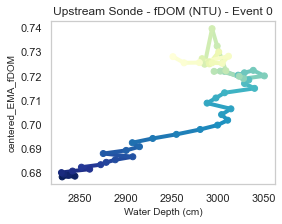

In [69]:
# Sonde for Event 1
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event0_up_sonde.index, event0_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event0_up_sonde.index, event0_up_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 0 - Upstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event0/event0_up_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event0_up_sonde.index, event0_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event0_up_sonde.index, event0_up_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 0 - Upstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event0/event0_up_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituen_name = ['Turbidity (FNU)', 'fDOM (RFU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event0_up_sonde['P3_EMA']))
    num_points = len(event0_up_sonde['P3_EMA'])
    colorline(event0_up_sonde['P3_EMA'], event0_up_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event0_up_sonde['P3_EMA'], event0_up_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Upstream Sonde - {constituent_dict[constituent]} - Event 0', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event0/event0_hysteresis_up_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 1

In [70]:
event1_up_sonde = up_sonde_clean.loc[event1_start:event1_end]
event1_up_sonde = event1_up_sonde.join(up_sonde['centered_EMA_fDOM'])
event1_up_constituents = up_constituents.loc[pd.Timestamp('2023-04-30 8:00:00'):pd.Timestamp('2023-05-01 14:00:00')]
# need to merge the depth and rest of data
event1_up_sonde = event1_up_sonde.merge(depths, left_index=True, right_index=True, how='left')
event1_up_constituents = event1_up_constituents.merge(depths, left_index=True, right_index=True, how='left')

upstream_events/event1/event1_up_SS_uL_L.jpg


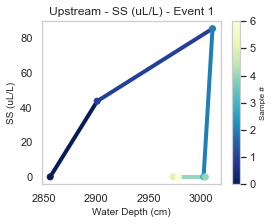

upstream_events/event1/event1_up_DOC_mg_L.jpg


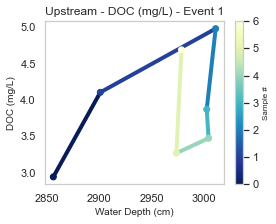

upstream_events/event1/event1_up_POC_mg_L.jpg


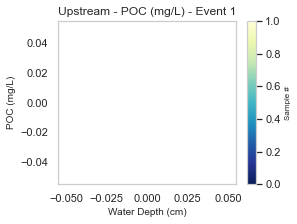

upstream_events/event1/event1_up_N_mg_L.jpg


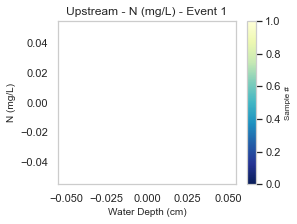

In [71]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event1_up_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event1_up_constituents[constituent])
    x = event1_up_constituents['P3_EMA'][mask]
    y = event1_up_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Upstream - {constituent} - Event 1', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event1/event1_up_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

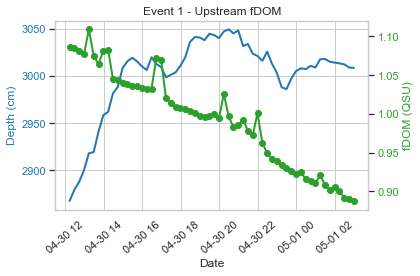

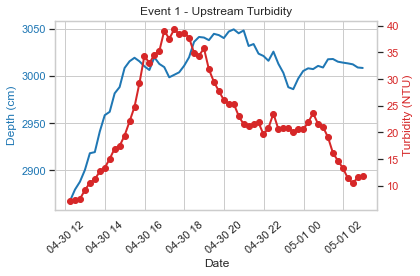

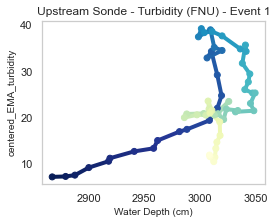

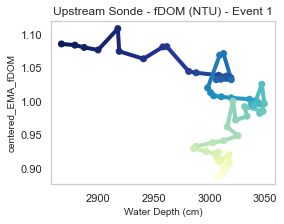

In [72]:
# Sonde for Event 1
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event1_up_sonde.index, event1_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event1_up_sonde.index, event1_up_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 1 - Upstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event1/event1_up_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event1_up_sonde.index, event1_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event1_up_sonde.index, event1_up_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 1 - Upstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event1/event1_up_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituen_name = ['Turbidity (FNU)', 'fDOM (RFU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event1_up_sonde['P3_EMA']))
    num_points = len(event1_up_sonde['P3_EMA'])
    colorline(event1_up_sonde['P3_EMA'], event1_up_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event1_up_sonde['P3_EMA'], event1_up_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Upstream Sonde - {constituent_dict[constituent]} - Event 1', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event1/event1_hysteresis_up_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 2

In [73]:
event2_up_sonde = up_sonde_clean.loc[event2_start:event2_end]
event2_up_sonde = event2_up_sonde.join(up_sonde['centered_EMA_fDOM'])
event2_up_constituents = up_constituents.loc[pd.Timestamp('2023-05-01 9:00:00'):pd.Timestamp('2023-05-02 10:00:00')]
# need to merge the depth and rest of data
event2_up_sonde = event2_up_sonde.merge(depths, left_index=True, right_index=True, how='left')
event2_up_constituents = event2_up_constituents.merge(depths, left_index=True, right_index=True, how='left')

upstream_events/event2/event2_up_SS_uL_L.jpg


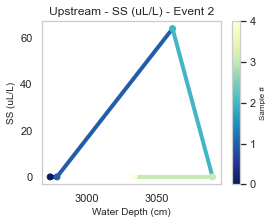

upstream_events/event2/event2_up_DOC_mg_L.jpg


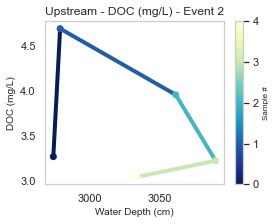

upstream_events/event2/event2_up_POC_mg_L.jpg


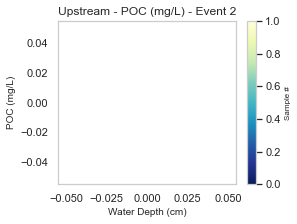

upstream_events/event2/event2_up_N_mg_L.jpg


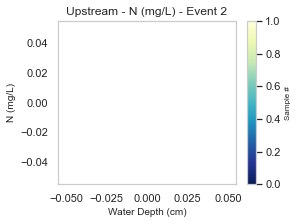

In [74]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event2_up_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event2_up_constituents[constituent])
    x = event2_up_constituents['P3_EMA'][mask]
    y = event2_up_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Upstream - {constituent} - Event 2', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event2/event2_up_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

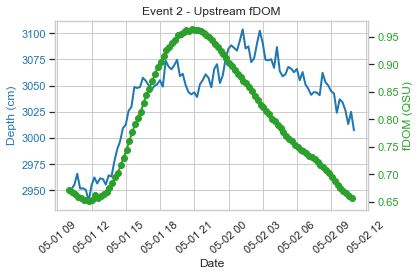

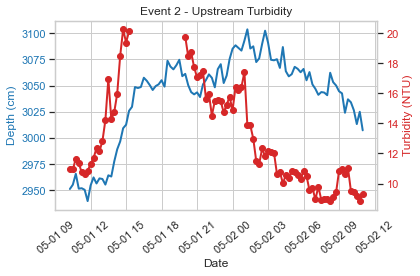

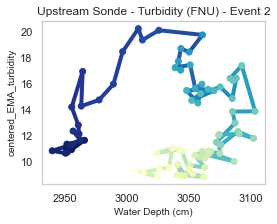

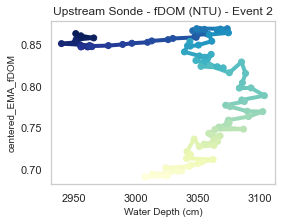

In [75]:
# Sonde for Event 2
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event2_up_sonde.index, event2_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event2_down_sonde.index, event2_down_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 2 - Upstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event2/event2_up_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event2_up_sonde.index, event2_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event2_up_sonde.index, event2_up_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 2 - Upstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event2/event2_up_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituen_name = ['Turbidity (FNU)', 'fDOM (RFU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event2_up_sonde['P3_EMA']))
    num_points = len(event2_up_sonde['P3_EMA'])
    colorline(event2_up_sonde['P3_EMA'], event2_up_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event2_up_sonde['P3_EMA'], event2_up_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Upstream Sonde - {constituent_dict[constituent]} - Event 2', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event2/event2_hysteresis_up_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 3

In [76]:
event3_up_sonde = up_sonde_clean.loc[event3_start:event3_end]
event3_up_sonde = event3_up_sonde.join(up_sonde['centered_EMA_fDOM'])
event3_up_constituents = up_constituents.loc[pd.Timestamp('2023-05-03 07:00:00'):pd.Timestamp('2023-05-04 08:00:00')]
# need to merge the depth and rest of data
event3_up_sonde = event3_up_sonde.merge(depths, left_index=True, right_index=True, how='left')
event3_up_constituents = event3_up_constituents.merge(depths, left_index=True, right_index=True, how='left')

upstream_events/event3/event3_up_SS_uL_L.jpg


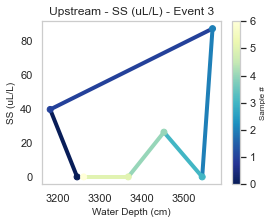

upstream_events/event3/event3_up_DOC_mg_L.jpg


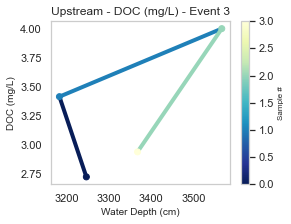

upstream_events/event3/event3_up_POC_mg_L.jpg


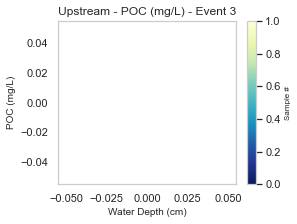

upstream_events/event3/event3_up_N_mg_L.jpg


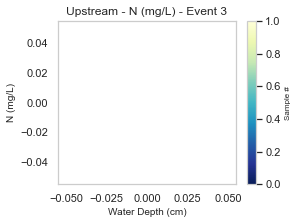

In [77]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event3_up_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event3_up_constituents[constituent])
    x = event3_up_constituents['P3_EMA'][mask]
    y = event3_up_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Upstream - {constituent} - Event 3', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event3/event3_up_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

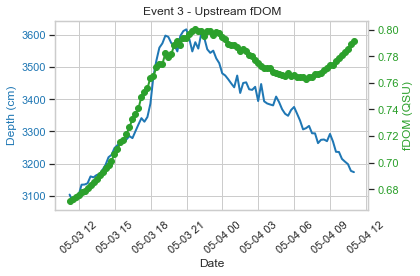

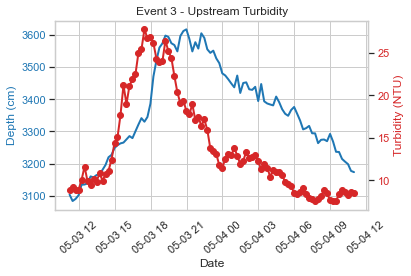

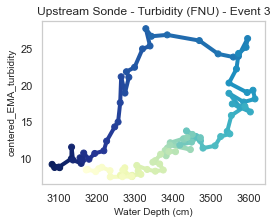

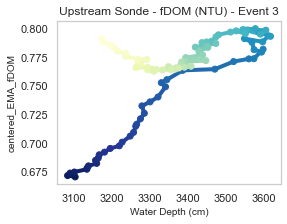

In [78]:
# Sonde for Event 3
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event3_up_sonde.index, event3_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event3_up_sonde.index, event3_up_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 3 - Upstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event3/event3_up_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event3_up_sonde.index, event3_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event3_up_sonde.index, event3_up_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 3 - Upstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event3/event3_up_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituen_name = ['Turbidity (FNU)', 'fDOM (RFU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event3_up_sonde['P3_EMA']))
    num_points = len(event3_up_sonde['P3_EMA'])
    colorline(event3_up_sonde['P3_EMA'], event3_up_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event3_up_sonde['P3_EMA'], event3_up_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Upstream Sonde - {constituent_dict[constituent]} - Event 3', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event3/event3_hysteresis_up_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Event 4

In [79]:
event4_up_sonde = up_sonde_clean.loc[event4_start:event4_end]
event4_up_sonde = event4_up_sonde.join(up_sonde['centered_EMA_fDOM'])
event4_up_constituents = up_constituents.loc[pd.Timestamp('2023-05-04 14:00:00'):pd.Timestamp('2023-05-05 5:00:00')]
# need to merge the depth and rest of data
event4_up_sonde = event4_up_sonde.merge(depths, left_index=True, right_index=True, how='left')
event4_up_constituents = event4_up_constituents.merge(depths, left_index=True, right_index=True, how='left')

upstream_events/event4/event4_up_SS_uL_L.jpg


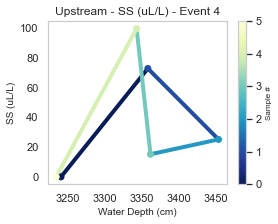

upstream_events/event4/event4_up_DOC_mg_L.jpg


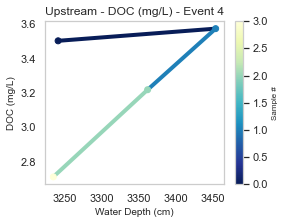

upstream_events/event4/event4_up_POC_mg_L.jpg


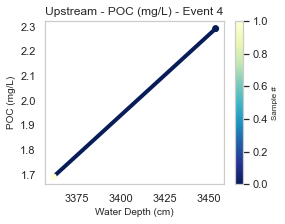

upstream_events/event4/event4_up_N_mg_L.jpg


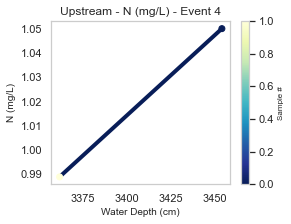

In [80]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event4_up_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event4_up_constituents[constituent])
    x = event4_up_constituents['P3_EMA'][mask]
    y = event4_up_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'Upstream - {constituent} - Event 4', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event4/event4_up_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory

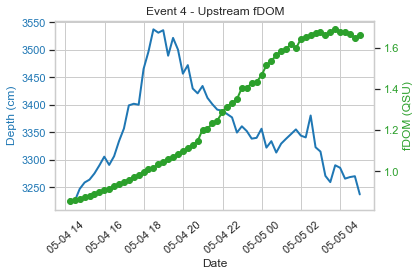

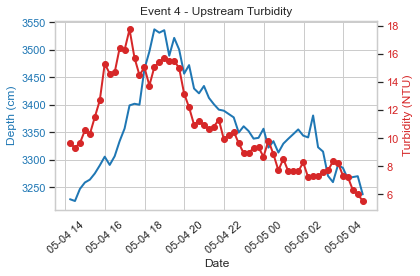

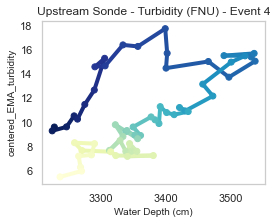

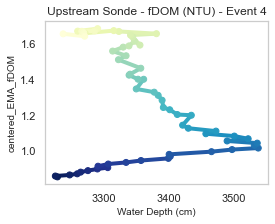

In [81]:
# Sonde for Event 1
# fDOM plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event4_up_sonde.index, event4_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('fDOM (QSU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event4_up_sonde.index, event4_up_sonde['centered_EMA_fDOM'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 4 - Upstream fDOM")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event4/event4_up_fDOM.jpg", dpi=300)
plt.show()

# Turbidity plot
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (cm)', color=color)
ax1.plot(event4_up_sonde.index, event4_up_sonde['P3_EMA'], color=color, linestyle="-", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=40)
ax2 = ax1.twinx()  # initiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Turbidity (NTU)', color=color)  # we already handled the x-label with ax1
ax2.plot(event4_up_sonde.index, event4_up_sonde['centered_EMA_turbidity'], "o-", color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Event 4 - Upstream Turbidity")
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("upstream_events/event3/event3_up_turbidity.jpg", dpi=1000)
plt.show()

# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'centered_EMA_fDOM'] # add fDOM later
constituen_name = ['Turbidity (FNU)', 'fDOM (RFU)'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event4_up_sonde['P3_EMA']))
    num_points = len(event4_up_sonde['P3_EMA'])
    colorline(event4_up_sonde['P3_EMA'], event4_up_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event4_up_sonde['P3_EMA'], event4_up_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'Upstream Sonde - {constituent_dict[constituent]} - Event 4', fontsize=12)
    ax1.set_ylabel(f"{constituent}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"upstream_events/event4/event4_hysteresis_up_sonde_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

### DOE PI Poster Plots

Sonde plots

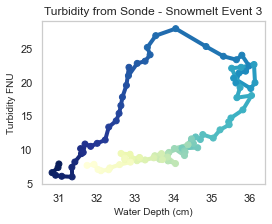

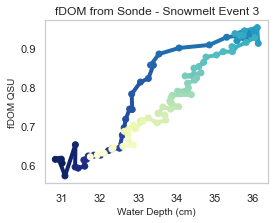

In [40]:
# Hysteresis plots
constituents = ['centered_EMA_turbidity', 'FDOM Fluorescence (RFU) (910042)'] # add fDOM later
constituent_names = ['Turbidity FNU', 'fDOM QSU'] # add fDOM later
constituent_dict = dict(zip(constituents, constituent_names))
cm = plt.cm.get_cmap('YlGnBu_r')
for constituent in constituents:
    fig, (ax1) = plt.subplots(figsize=(4,3))
    plt.sca(ax1)
    z = np.linspace(0, 1, len(event3_down_sonde['P3_EMA']))
    num_points = len(event3_down_sonde['P3_EMA'])
    colorline(event3_down_sonde['P3_EMA'], event3_down_sonde[constituent], z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    sc =ax1.scatter(event3_down_sonde['P3_EMA'], event3_down_sonde[constituent], c=range(num_points), cmap=cm, zorder=100)
    plt.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax1.set_title(f'{constituent_dict[constituent][:-4]} from Sonde - Snowmelt Event 3', fontsize=12)
    ax1.set_ylabel(f"{constituent_dict[constituent]}", fontsize=10)
    ax1.set_xlabel("Water Depth (cm)", fontsize=10)
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"poster_hysteresis_SONDE_{safe_constituent}.jpg"
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()

Constituent plots

poster_hysteresis_SS_uL_L.jpg


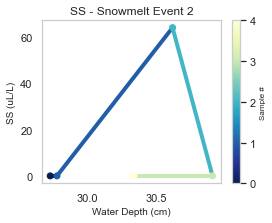

poster_hysteresis_DOC_mg_L.jpg


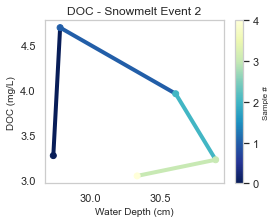

poster_hysteresis_POC_mg_L.jpg


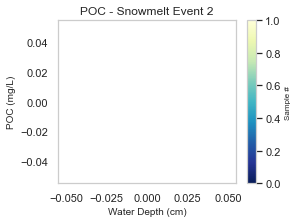

poster_hysteresis_N_mg_L.jpg


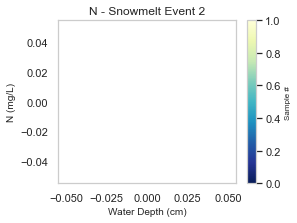

In [41]:
# single plot - downstream event 1
constituents = ['SS (uL/L)', 'DOC (mg/L)', 'POC (mg/L)', 'N (mg/L)']
cm = plt.cm.get_cmap('YlGnBu_r')

for constituent in constituents:
    if constituent not in event2_up_constituents.columns:
        continue

    fig, ax = plt.subplots(figsize=(4, 3))  # create a new figure for each constituent
    plt.sca(ax)  # set the current axes to ax
    
    # filter out NaN values
    mask = ~np.isnan(event2_up_constituents[constituent])
    x = event2_up_constituents['P3_EMA'][mask]
    y = event2_up_constituents[constituent][mask]

    z = np.linspace(0, 1, len(x))
    num_points = len(x)
    colorline(x, y, z, cmap=plt.get_cmap('YlGnBu_r'), linewidth=4)
    
    # use a range of integers to represent colors
    c = np.arange(num_points)
    sc = ax.scatter(x, y, c=c, cmap=cm, zorder=100)
    
    ax.grid(False)
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Sample #', size=8)
    ax.set_title(f'{constituent[:-7]} - Snowmelt Event 2', fontsize=12)
    ax.set_ylabel(f"{constituent}", fontsize=10)
    ax.set_xlabel("Water Depth (cm)", fontsize=10)

    # replace special characters in the filename
    safe_constituent = constituent.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    filename = f"poster_hysteresis_{safe_constituent}.jpg"
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=1000)
    plt.show()
    plt.close(fig)  # close the figure to free up memory